In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [6]:
!wget -O lfw.tgz --no-check-certificate "http://vis-www.cs.umass.edu/lfw/lfw.tgz"

--2022-02-01 17:16:53--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  32.2MB/s    in 6.0s    

2022-02-01 17:16:59 (28.8 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [7]:
!tar -xzvf "/content/lfw.tgz" -C "/content"     #[run this cell to extract tar.gz files]

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

In [8]:
#dump all the images from lfw to the negative folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH= os.path.join('lfw',directory,file)
        NEW_PATH= os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [9]:
rm -r -f lfw/ lfw.tgz

In [10]:
rm -r -f sample_data/

In [16]:
#get the data from the local system to the colab environment

In [11]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)


In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'data/anchor/5016eac8-8363-11ec-b99c-30c9ab8a407a.jpg'


In [14]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

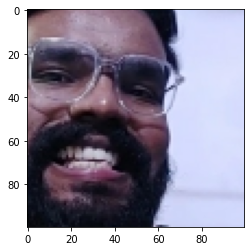

In [15]:
img = preprocess(dir_test.next()) #'data/anchor/5686d244-8363-11ec-9d2e-30c9ab8a407a.jpg'
img.numpy().max() 
plt.imshow(img)

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
example = samples.next()

In [19]:
example

(b'data/anchor/47a21a44-8363-11ec-af25-30c9ab8a407a.jpg',
 b'data/positive/90b6de7c-8363-11ec-ac46-30c9ab8a407a.jpg',
 1.0)

In [20]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [21]:
res = preprocess_twin(*example)

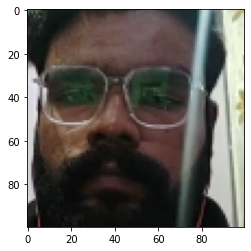

In [22]:
plt.imshow(res[1])

In [23]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=len(data))

In [24]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [25]:
# Training partition
train_data = data.take(round(len(data)*.7)) # take 70% of the data for training
train_data = train_data.batch(16)
train_data = train_data.prefetch(8) #prefetches next 8 images and preprocess, while the batch of 16 are used for input

In [26]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model building

In [27]:
#embedding model
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [28]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

# Distance layer

In [29]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [30]:
l1 = L1Dist()

In [31]:
# l1(anchor_embedding, validation_embedding)

# Make siamese network

In [32]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)

classifier = Dense(1, activation='sigmoid')(distances)

siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [33]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

In [34]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [35]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [36]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]

In [42]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    # print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [43]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss= train_step(batch)
            print(f"The loss is:> {loss}")
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [44]:
EPOCHS = 150
train(train_data, EPOCHS)


 Epoch 1/150
The loss is:> 5.23640846950002e-05
27/27 [==============================] - 21s 760ms/step

 Epoch 2/150
The loss is:> 0.00010058490443043411
27/27 [==============================] - 20s 744ms/step

 Epoch 3/150
The loss is:> 1.015922043734463e-05
27/27 [==============================] - 20s 743ms/step

 Epoch 4/150
The loss is:> 0.00015700297080911696
27/27 [==============================] - 20s 743ms/step

 Epoch 5/150
The loss is:> 7.958889909787104e-05
27/27 [==============================] - 20s 742ms/step

 Epoch 6/150
The loss is:> 0.00015119597082957625
27/27 [==============================] - 20s 742ms/step

 Epoch 7/150
The loss is:> 0.00025075534358620644
27/27 [==============================] - 20s 742ms/step

 Epoch 8/150
The loss is:> 4.120220637560124e-06
27/27 [==============================] - 20s 740ms/step

 Epoch 9/150
The loss is:> 4.6838449634378776e-05
27/27 [==============================] - 20s 741ms/step

 Epoch 10/150
The loss is:> 7.96711028669

In [46]:
siamese_model.save('siamesemodel_150_epochs.h5')

# Evaluation and metrics

In [45]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [53]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
print(y_hat)

# Post processing the results 
print([1 if prediction > 0.5 else 0 for prediction in y_hat ])

print(y_true)

[[9.9997628e-01]
 [5.7022191e-09]
 [1.3844503e-07]
 [1.0000000e+00]
 [5.1369549e-09]
 [1.8002647e-09]
 [9.9999917e-01]
 [9.9999952e-01]
 [9.9997401e-01]
 [9.9999201e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [4.4922722e-13]
 [1.8425482e-10]
 [9.9999225e-01]
 [9.9997854e-01]]
[1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
[1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.]


In [48]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [49]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

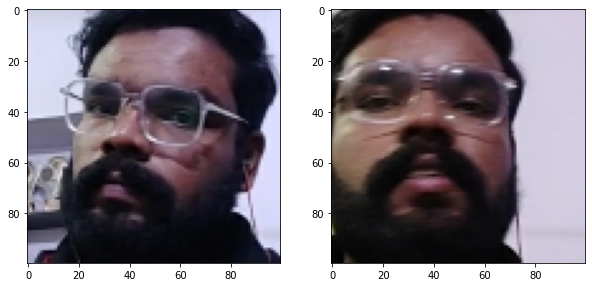

In [50]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [51]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel_150_epochs.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [52]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[9.9999988e-01],
       [1.0000000e+00],
       [1.2028853e-11],
       [1.0000000e+00],
       [8.4787164e-09],
       [1.0000000e+00],
       [9.9999976e-01],
       [8.6134242e-12],
       [1.4841488e-09],
       [1.0000000e+00],
       [4.1659398e-13],
       [1.0000000e+00],
       [3.2111631e-12],
       [9.9999940e-01],
       [9.9999785e-01],
       [9.9998629e-01]], dtype=float32)